<a href="https://colab.research.google.com/github/Osmanov-Bairam/MKB_BANK/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Define the problem

Банковская гарантия — соглашение, по которому банк обязан выплатить долг клиента, если тот не выполнил своих обязательств. Выдача гарантий банком происходит после одобрения клиентской заявки.


Задача — построить аппликационную модель оценки вероятности предъявления по гарантии, чтобы минимизировать потери от кредитного риска. В качестве предикторов для моделирования используются анкетные данные клиента и его финансовые показатели.

# Import libraries

In [1]:
!pip install scikit-learn-intelex

     |████████████████████████████████| 69 kB 3.2 MB/s 
     |████████████████████████████████| 22.5 MB 1.5 MB/s 
     |████████████████████████████████| 284.3 MB 2.1 kB/s 
     |████████████████████████████████| 4.0 MB 51.3 MB/s 


In [2]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 58 kB/s 


In [3]:
!pip install shap

     |████████████████████████████████| 564 kB 4.9 MB/s 


In [4]:

#load packages
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

Python version: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
pandas version: 1.1.5
matplotlib version: 3.2.2
NumPy version: 1.19.5
SciPy version: 1.4.1
IPython version: 5.5.0
scikit-learn version: 1.0.2
-------------------------


In [5]:
#other libraries
import random
import time
import os
import requests
import collections
import pickle
from tqdm import tqdm

In [6]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.pipeline import Pipeline

#Uncommon Model Algorithms
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score
from catboost import Pool

# to split the datasets
from sklearn.model_selection import train_test_split

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
# from pandas.tools.plotting import scatter_matrix
import missingno as msno


In [7]:
# from feature-engine

! pip install feature-engine

     |████████████████████████████████| 205 kB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 47.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [8]:
# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    RandomSampleImputer,
)

# Presetting

In [9]:
#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline

mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [10]:
# To plot pretty figures

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [11]:
# Connect to google drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [12]:
# Where to save the figures

IMAGES_PATH = "/content/gdrive/MyDrive/Plots"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [13]:
path_pikcle = "/content/gdrive/MyDrive/Dataset/Pickles"

# Gather & Import the data

In [ ]:
path_data = "/content/gdrive/MyDrive/Dataset/Bank_Data/train_dataset_hackathon_mkb.csv"
data = pd.read_csv(path_data,  sep=';', encoding ='cp1251')

In [ ]:
path_decrib = "/content/gdrive/MyDrive/Dataset/Bank_Data/data_description.xlsx"
describ = pd.read_excel(path_decrib)

# Meet and Greet Data

In [ ]:
data.head()

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,...,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,1,1847,01JAN2018:00:00:00,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,NaN,21224000.0,1.048287e+10,105901000.0,127510000.0,9.477348e+09,440671000.0,3.312980e+08,138000.0,1.960896e+09,1.000700e+07,-46634000.0,599497000.0,500000.0,1.028878e+09,340135000.0,NaN,340135000.0,NaN,9.480796e+09,2.499973e+09,6.907960e+09,NaN,NaN,1.178183e+10,1.178183e+10,2.370882e+09,5.294104e+10,5.057016e+10,631752000.0,...,0.0,0.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,4650,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4770,01JAN2018:00:00:00,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,NaN,NaN,2.161000e+07,2378000.0,NaN,1.764200e+07,1000000.0,5.530000e+05,37000.0,9.073600e+07,1.000000e+05,NaN,6780000.0,NaN,8.385600e+07,NaN,NaN,NaN,NaN,4.248000e+06,NaN,4.171000e+06,77000.0,NaN,9.498400e+07,9.498400e+07,9.315000e+06,5.218400e+07,4.286900e+07,2569000.0,...,1.0,1.0,36.00.2,6.0,2762852.0,1.0,794.0,3.0,21.0,5408695.0,39.0,882647.0,4.0,1.0,0.0,1.0,1.0,1174998.0,2.0,0.0,2.0,2.0,2738217.0,38.0,0.0,38.0,39.0,4209963.0,169.0,0.0,169.0,168.0,18351739.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,4,12237,01JAN2018:00:00:00,0,0,1.937488e+09,122828000.0,6.103280e+08,NaN,809426000.0,356828000.0,38078000.0,5.786965e+09,12001000.0,71000.0,1.232486e+09,78603000.0,4.459193e+09,4611000.0,2.685905e+09,1.516514e+09,NaN,NaN,65834000.0,1.103557e+09,627253000.0,NaN,689000.0,626564000.0,4.411295e+09,3.930000e+05,3.092581e+09,NaN,NaN,7.724453e+09,7.724453e+09,1.694054e+10,4.028466e+10,2.334412e+10,931118000.0,...,1.0,1.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,9988,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17891 entries, 0 to 17890
Columns: 124 entries, id_contract to CITIZENSHIP_NAME
dtypes: float64(108), int64(4), object(12)
memory usage: 16.9+ MB


In [ ]:
# data balance

data["TARGET"].value_counts()

0    10502
1     7389
Name: TARGET, dtype: int64

Вывод - дисбаланс в классах

# Split thee data

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["TARGET"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [ ]:
data1 = strat_train_set.copy(deep = True).sort_values(by=['SIGN_DATE','id_client'])
data_val = strat_test_set.copy(deep = True).sort_values(by=['SIGN_DATE','id_client'])

# Research on fullness

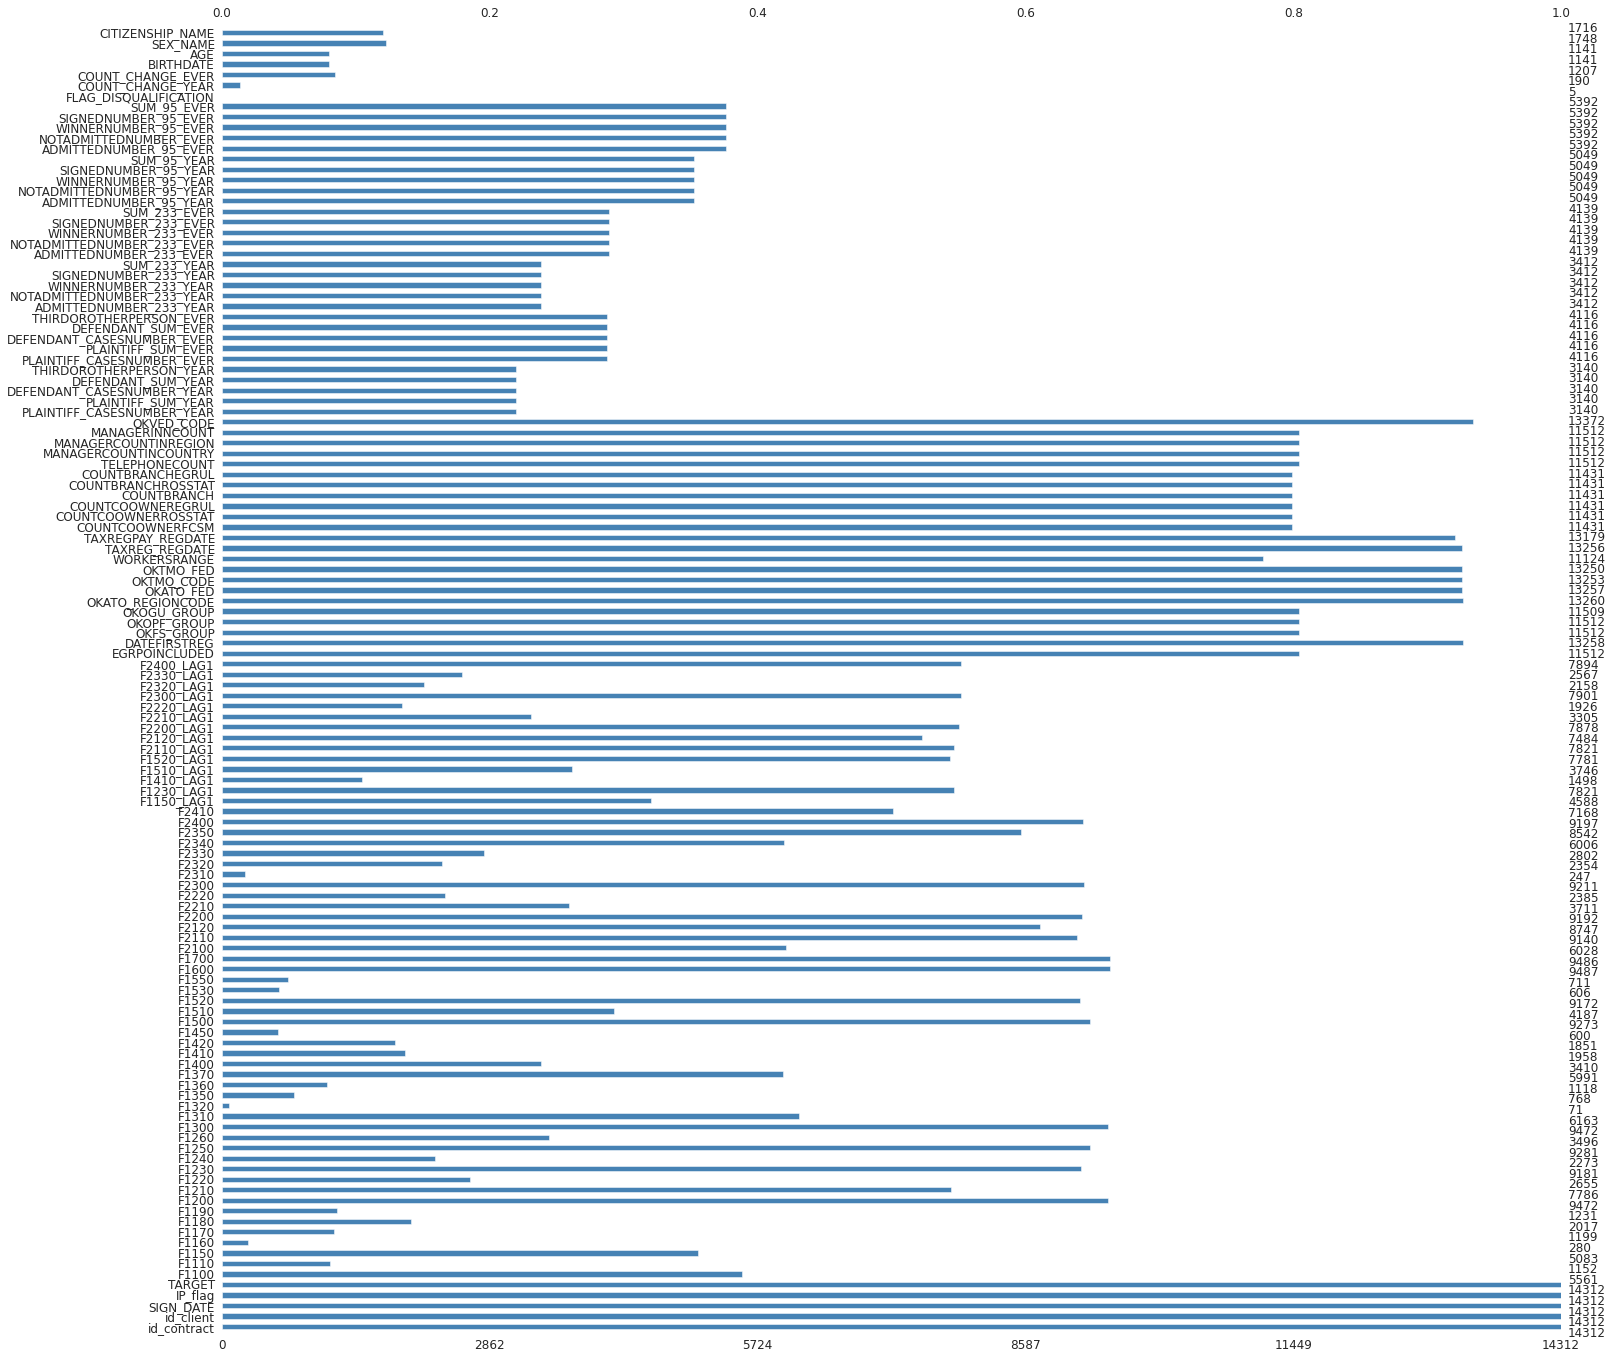

In [ ]:
# how much is null on columns level

msno.bar(data1, figsize=(24, 24), fontsize=12, color='steelblue');
# save_fig("Empty")

Вывод - только IP_flag, SIGN_DATA, id_client и id_contract заполнены для всех клиентов.

In [ ]:
client = (data["id_client"].value_counts() > 1).mean().round(2)*100
contract = (data["id_contract"].value_counts() > 1).mean().round(2)*100

In [ ]:
print("Percent of same clients %: ",  client)
print("Percent of same contracts %: ",  contract)

Percent of same clients %:  19.0
Percent of same contracts %:  0.0


Вывод - повторы наблюдений в таблице могут помочь найти значения пустых ячеек, принадлежащие этим наблюдениям.

In [ ]:
# how much is null in row level

def add_feature_full(data):
  for index, row in pd.notna(data).iterrows():
    data.loc[index, "Fullness"] = row.mean().round(2)

In [ ]:
add_feature_full(data1)
add_feature_full(data_val)

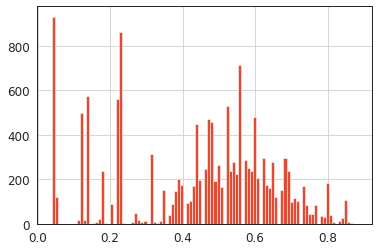

In [ ]:
data1["Fullness"].hist(bins = 100)

Вывод - есть наблюдения, где отсутсвуют большинство данных.


# Time sequence research

In [ ]:
dates = ["TAXREG_REGDATE", "TAXREGPAY_REGDATE", "SIGN_DATE", "DATEFIRSTREG"]
data_temp_time = data1.copy()
data_temp_time[dates].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14312 entries, 3391 to 11481
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   TAXREG_REGDATE     13256 non-null  object
 1   TAXREGPAY_REGDATE  13179 non-null  object
 2   SIGN_DATE          14312 non-null  object
 3   DATEFIRSTREG       13258 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB


In [ ]:
# change the type
for d in dates:
  data_temp_time[d] = pd.to_datetime(data[d], format='%d%b%Y:%H:%M:%S')

In [ ]:
data_temp_time[dates].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14312 entries, 3391 to 11481
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TAXREG_REGDATE     13256 non-null  datetime64[ns]
 1   TAXREGPAY_REGDATE  13179 non-null  datetime64[ns]
 2   SIGN_DATE          14312 non-null  datetime64[ns]
 3   DATEFIRSTREG       13258 non-null  datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 1.2 MB


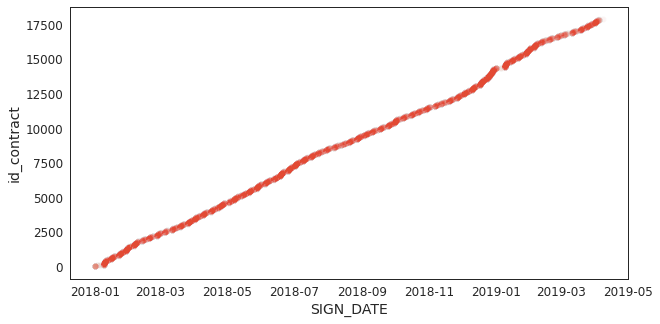

In [ ]:
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 5))
sns.scatterplot(data=data_temp_time, x="SIGN_DATE", y="id_contract", alpha=0.01)

Вывод "SIGN_DATE" можно заменить датой слева и справа

# Data Imputation

Imputation technic №1

---



We impute missing categorical features for clients who attend bank more than 1 time

Impute date 

Imputation technic №2

---



Random sampling imputation is in principle similar to mean / median / mode imputation, in the sense that it aims to preserve the statistical parameters of the original variable, for which data is missing.

Random sampling consist of taking a random observation from the pool of available observations of the variable, and using that randomly extracted value to fill the NA. In random sample imputation one takes as many random observations as missing values are present in the variable.

We do not know whether data are missing at random or not. It is a good idea to replace missing observations by random value AND flag those missing observations as well with a Missing Indicator. A Missing Indicator is an additional binary variable, which indicates whether the data was missing for an observation (1) or not (0).



In [ ]:
pipe = Pipeline([
    ('missing_ind', AddMissingIndicator()),

    ('imputer_random', RandomSampleImputer(random_state = 42))
])

In [ ]:
pipe.fit(data1)
imputed_train_v2 = pipe.transform(data1)
imputed_test_v2 = pipe.transform(data_val)

In [ ]:
# checking

print("Columns with missing values in train:")
[feature for feature in imputed_train_v2.columns if imputed_train_v2.isnull().any()[feature] == True]

Columns with missing values in train:


[]

In [ ]:
imputed_train_v2.name = 'imputed_train_v2'
imputed_test_v2.name = 'imputed_test_v2'

In [ ]:
imputed_list = [imputed_train_v2, imputed_test_v2]

# Feature construction

Debt features


In [ ]:
def construct_debt_features(data):

  # all debt
  data['debt'] = (data['F1410']+data['F1510'])
  # ratio
  data['debt_on_profit'] = (data['F1410']+data['F1510'])/data['F2110']
  # ratio from past
  data['debt_on_profit_LAG1'] = (data['F1410_LAG1']+data['F1510_LAG1'])/data['F2110_LAG1']
  # change absolut
  data['debt_on_profit_diff']  = data['debt_on_profit'] - data['debt_on_profit_LAG1']
  # change relative
  data['debt_on_profit_diff_ratio']  = (data['debt_on_profit'] - data['debt_on_profit_LAG1'])/data['debt_on_profit']

  print("Debt feature construction is completed")

Arbitrage and bid features. 

In [ ]:
def construct_ratio_features(data):
  # for convinience
  data.rename(columns={'NOTADMITTEDNUMBER_EVER': 'NOTADMITTEDNUMBER_95_EVER','THIRDOROTHERPERSON_YEAR':'THIRDOROTHERPERSON_CASESNUMBER_YEAR',
                        'THIRDOROTHERPERSON_EVER':'THIRDOROTHERPERSON_CASESNUMBER_EVER'}, inplace=False)    
  # for iteration
  ever_year_info = ['PLAINTIFF_SUM','PLAINTIFF_CASESNUMBER','DEFENDANT_CASESNUMBER','DEFENDANT_SUM', 'THIRDOROTHERPERSON_CASESNUMBER',
                    'ADMITTEDNUMBER_233','NOTADMITTEDNUMBER_233','WINNERNUMBER_233', 'SIGNEDNUMBER_233','SUM_233','ADMITTEDNUMBER_95',
                    'NOTADMITTEDNUMBER_95','SIGNEDNUMBER_95', 'WINNERNUMBER_95','SUM_95','COUNT_CHANGE']

  for col in ever_year_info:
      # compare bit and arbitrage of this year with history 
      # -1 if there is no value in the history
      func_ration = lambda x: -1 if x['{}_EVER'.format(col)] == 0 else x['{}_YEAR'.format(col)]/x['{}_EVER'.format(col)]
      data['RATIO_YEAR_EVER_{}'.format(col)] = data[['{}_YEAR'.format(col), '{}_EVER'.format(col)]].apply(func_ration, axis=1)

  print("Ratio feature construction is completed")

Arbitrage only features

In [ ]:
def construct_arbitrage_features(data):
  tender_info = ['NUMBER_233_YEAR','NUMBER_233_EVER', 'NUMBER_95_YEAR','NUMBER_95_EVER']

  data.rename(columns={'NOTADMITTEDNUMBER_EVER': 'NOTADMITTEDNUMBER_95_EVER','THIRDOROTHERPERSON_YEAR':'THIRDOROTHERPERSON_CASESNUMBER_YEAR',
                        'THIRDOROTHERPERSON_EVER':'THIRDOROTHERPERSON_CASESNUMBER_EVER'}, inplace=True)  
    
  for col in tender_info:
      # total 
      data['SUM_ADM_NOTADM_{}'.format(col)] = (data['ADMITTED{}'.format(col)] + data['NOTADMITTED{}'.format(col)] )
      
      # Percent of admitted cases
      func_ratio = lambda x: -1 if x['NOTADMITTED{}'.format(col)] + x['ADMITTED{}'.format(col)] == 0 else x['ADMITTED{}'.format(col)] / (x['NOTADMITTED{}'.format(col)]+x['ADMITTED{}'.format(col)])
      data['RATIO_ADMIT_{}'.format(col)] = data[['ADMITTED{}'.format(col), 'NOTADMITTED{}'.format(col)]].apply(func_ratio, axis=1)

      # Percent of winned cases
      func_ratio = lambda x: -1 if x['ADMITTED{}'.format(col)] == 0 else x['WINNER{}'.format(col)] / x['ADMITTED{}'.format(col)]
      data['RATIO_WIN_{}'.format(col)] = data[['WINNER{}'.format(col), 'ADMITTED{}'.format(col)]].apply(func_ratio, axis=1)
      
      # Percent of signed cases after winning
      func_ratio = lambda x: -1 if x['WINNER{}'.format(col)] == 0 else x['SIGNED{}'.format(col)] / x['WINNER{}'.format(col)]
      data['RATIO_WIN_SIG_{}'.format(col)] = data[['WINNER{}'.format(col), 'SIGNED{}'.format(col)]].apply(func_ratio, axis=1)


  judge_info = ['CASESNUMBER_YEAR', 'CASESNUMBER_EVER']
  judge_info_2 = ['SUM_EVER', 'SUM_YEAR']

  for col in judge_info:

      # total cases in arbitrage
      data['SUM_PLA_DEF_THI_{}'.format(col)] = data['PLAINTIFF_{}'.format(col)] + data['DEFENDANT_{}'.format(col)] + data['THIRDOROTHERPERSON_{}'.format(col)]

      # case ratio
      func_ration = lambda x: -1 if x['THIRDOROTHERPERSON_{}'.format(col)] == 0 else x['DEFENDANT_{}'.format(col)] /x['THIRDOROTHERPERSON_{}'.format(col)]
      data['RATIO_DEF_THI_{}'.format(col)] = data[['DEFENDANT_{}'.format(col), 'THIRDOROTHERPERSON_{}'.format(col)]].apply(func_ration, axis=1)

      # case ratio
      func_ration = lambda x: -1 if x['PLAINTIFF_{}'.format(col)] + x['DEFENDANT_{}'.format(col)] == 0 else x['DEFENDANT_{}'.format(col)] /(x['PLAINTIFF_{}'.format(col)] + x['DEFENDANT_{}'.format(col)])
      data['RATIO_DEF_THI_DEF_{}'.format(col)] = data[['DEFENDANT_{}'.format(col), 'PLAINTIFF_{}'.format(col)]].apply(func_ration, axis=1)

  for col in judge_info_2:

      # total cases in arbitrage without THIRDOROTHERPERSON
      data['SUM_PLA_DEF_{}'.format(col)] = data['PLAINTIFF_{}'.format(col)] + data['DEFENDANT_{}'.format(col)]

      # case ratio
      func_ration = lambda x: -1 if x['PLAINTIFF_{}'.format(col)] == 0 else x['DEFENDANT_{}'.format(col)]/x['PLAINTIFF_{}'.format(col)]
      data['RATIO_DEF_THI_{}'.format(col)] = data[['DEFENDANT_{}'.format(col), 'PLAINTIFF_{}'.format(col)]].apply(func_ration, axis=1)

      # DEFENDANT percent out of total
      func_ratio = lambda x: -1 if x['PLAINTIFF_{}'.format(col)] + x['DEFENDANT_{}'.format(col)] == 0 else x['DEFENDANT_{}'.format(col)]/(x['PLAINTIFF_{}'.format(col)] + x['DEFENDANT_{}'.format(col)])
      data['RATIO_DEF_THI_DEF_{}'.format(col)] = data[['DEFENDANT_{}'.format(col),'PLAINTIFF_{}'.format(col)]].apply(func_ratio, axis=1)


  arb_info = ['PLAINTIFF', 'DEFENDANT']
  num2sum = {'CASESNUMBER_YEAR' : 'SUM_YEAR', 'CASESNUMBER_EVER' : 'SUM_EVER'}
  
  for number, summa in num2sum.items():
      for col in arb_info:
          # avarage amount of money per arbitrage case in 1 observation
          func_ration = lambda x: -1 if x['{}_{}'.format(col, number)] == 0 else x['{}_{}'.format(col, summa)]/x['{}_{}'.format(col, number)]
          data['RATIO_SUM_NUMBER_{}_{}'.format(col, number.split('_')[-1])] = data[['{}_{}'.format(col, summa), '{}_{}'.format(col, number)]].apply(func_ration, axis=1)
  
  print("Arbitrage feature construction is completed")  

Time, code and quantity features

In [ ]:
def construct_time_code_features(data):

  # add labels for quantity of people in firm
  str2num = { '5000 и более': 12, '1001 .. 5000': 11, '501 .. 1000': 10, '251 .. 500': 9, '201 .. 250': 8, '151 .. 200': 7,
            '101 .. 150': 6, '51 .. 100': 5, '16 .. 50': 4, '11 .. 15': 3, '6 .. 10': 2, '0 .. 5': 1}
  data['WORKERSRANGE'] = data['WORKERSRANGE'].map(str2num).astype(float)


  dates = ["TAXREG_REGDATE", "TAXREGPAY_REGDATE", "SIGN_DATE", "DATEFIRSTREG"]
  
  # change the type
  for d in dates:
      data[d] = pd.to_datetime(data[d], format='%d%b%Y:%H:%M:%S')

  # time difference between all events
  for i in dates:
      for j in dates:
          if i != j:
              data["{}_{}_year_delta".format(i, j)] = data[i].dt.year - data[j].dt.year 
              data["{}_{}_month_delta".format(i, j)] = ((data[i] - data[j]).astype('timedelta64[D]')/ 28).round()
              data["{}_{}_day_delta".format(i, j)] = (data[i] - data[j]).astype('timedelta64[D]')
  
  data["F_sing_date_year"] = data['SIGN_DATE'].dt.year


  # derive specialization and company locations from codes
  for step in [2, 4, 5, 7, 8]:
      data['OKVED_CODE_{}'.format(step)] = data['OKVED_CODE'].str[:step]

  data['OKTMO_CODE'] = data['OKTMO_CODE'].astype(str)
  for step in [2, 5, 8]:
      data['OKTMO_CODE_{}'.format(step)] = data['OKTMO_CODE'].str[:step]

  print("Time, code and people feature construction is completed")  

Financial features

In [ ]:
    def construct_fin_features(data):
      
      # profitability metrices
      data['F_fin_2200_2'] = data['F2200']/(data['F2120'] + data['F2210'] + data['F2220'])
      data['F_fin_2400_2110'] = data['F2400']/data['F2110']    
      data['F_fin_2300_1300'] = data['F2300']/(data['F1300'] + data['F1530'] + data['F1400'])
      data['F_fin_2300_2110'] = data['F2300']/data['F2110']
      data['F_fin_2400_1300_1500'] = data['F2400']/(data['F1300'] + data['F1530'])
      data['F_fin_2400_1600'] = data['F2400']/data['F1600']
      data['F_fin_2400_2110_LAG1'] = data['F2400_LAG1']/data['F2110_LAG1']
      data['F_fin_2400_2110_diff_ratio'] = (data['F_fin_2400_2110'] - data['F_fin_2400_2110_LAG1'])/data['F_fin_2400_2110']
      data['F_fin_2300_2110_LAG1'] = data['F2300_LAG1']/data['F2110_LAG1']
      data['F_fin_2300_2110_LAG1_diff_ratio'] = (data['F_fin_2300_2110'] - data['F_fin_2300_2110_LAG1'])/data['F_fin_2300_2110']

      # lequidity and turnover
      data['F_fin_1200_2'] = data['F1200'] - data['F1500'] - data['F1530'] 
      data['F_fin_1240_1'] = (data['F1240'] + data['F1250'])/( data['F1500'] + data['F1530'])
      data['F_fin_1240_2'] = (data['F1240'] + data['F1250'] + data['F1230'])/( data['F1500'] + data['F1530'])
      data['F_fin_1200_1'] = data['F1200']/( data['F1500'] + data['F1530'] )
      data['F_fin_2110_1230'] = data['F2110']/data['F1230'] 
      data['F_fin_2120_1210'] = data['F2120']/data['F1210']
      data['F_fin_2110_1230_LAG1'] = data['F2110_LAG1']/data['F1230_LAG1']
      data['F_fin_2110_1230_diff_ratio'] = (data['F_fin_2110_1230'] - data['F_fin_2110_1230_LAG1'])/data['F_fin_2110_1230']

      # debt lequidity
      data['F_21'] = data['F2110'] / ((data['F1230'] + data['F1230_LAG1'])/2)
      data['F_22'] = data['F2120'] / ((data['F1520'] + data['F1520_LAG1'])/2)

      # stability
      data['F_fin_1_1700'] = (data['F1300'] + data['F1530'] )/data['F1700']
      data['F_fin_2_1700'] = (data['F1400'] + data['F1500']  - data['F1530'] )/data['F1700']
      data['F_fin_1400'] = (data['F1400'] + data['F1500']  - data['F1530'] )/(data['F1300'] + data['F1530'])
      data['F_fin_1300'] = (data['F1300'] + data['F1530']  - data['F1100'])/(data['F1300'] + data['F1530'])
      data['F_fin_1300_1'] = (data['F1300'] + data['F1530'] - data['F1100'])/data['F1200']

      # others
      data['FE1700'] = data['F2110'] + data['F2120'] + data['F2100'] + data['F2210']+ data['F2220'] + data['F2200'] + data['F2350'] + data['F2300'] + data['F2410'] + data['F2400']
      data['F_sum_active_pass'] = data['F1700'] + data['F1600']
      data['F_active_on_pass'] = data['F1600']/(data['F1600']+data['F1700'])
      data['F_active_on_pass_ration'] = data['F1600']/(data['F1700'])
      func_ratio = lambda x: -1 if x['F1410'] + x['F1510'] == 0 else (x['F1600'] + x['F1700'])/(x['F1410'] + x['F1510'])
      data['debt_on_sum_act_pas'] = data[['F1700','F1600','F1410','F1510']].apply(func_ratio, axis=1)

      print("Financial features construction is completed")  

In [ ]:
def construct_grouped_features(tr_data, te_data=None, test_flag=False):

    # we need to construct descriptive statistic features for test set by taking into account train set data
    if test_flag:
        data = pd.concat([tr_data, te_data], ignore_index = True)
    else:
        data = tr_data.copy()
         
    # years passed from different events
    data['year_from_DATEFIRSTREG'] = ((data['SIGN_DATE'] - data['DATEFIRSTREG']).astype('timedelta64[D]') / 365).round()
    data['year_from_TAXREG_REGDATE'] = ((data['SIGN_DATE'] - data['TAXREG_REGDATE']).astype('timedelta64[D]') / 365).round()
    data['year_from_TAXREGPAY_REGDATE'] = ((data['SIGN_DATE'] - data['TAXREGPAY_REGDATE']).astype('timedelta64[D]') / 365).round()

    # how much days passed after first deal with the bank
    data['day_from_first_SIGN_DATE'] = (data.groupby('id_client')['SIGN_DATE'].transform('min') - data['SIGN_DATE']).astype('timedelta64[D]')  

    # how many flags per client
    data['F_IP_flag_sum'] = data.groupby("id_client", as_index=False)["IP_flag"].transform('sum')

    # how many times client returned to to the bank
    data['F_contract_count'] = data.groupby("id_client", as_index=False)["id_contract"].transform("count")

    # 
    data['F_contract_count_in_day'] = data.groupby(['id_client','SIGN_DATE'])['SIGN_DATE'].transform('count')    

    #
    trend = lambda x : x.iloc[-1] - x.iloc[0]
    data['F_contract_count_in_day_trend'] = data[['id_client','F_contract_count_in_day']].groupby('id_client', as_index=False)['F_contract_count_in_day'].transform(trend)


    # standart deviation and mean for each case
    data['F_contract_count_in_day_std'] = data[['id_client','F_contract_count_in_day']].groupby('id_client', as_index=False).transform('std').fillna(0)
    data['F_contract_count_mean'] = data[['id_client','F_contract_count']].groupby('id_client', as_index=False).transform('mean')
    data['F_WORKERSRANGE_change_mean'] = data[['id_client','WORKERSRANGE']].groupby('id_client', as_index=False).transform('mean')
    data['F_WORKERSRANGE_change_std'] = data[['id_client','WORKERSRANGE']].groupby('id_client', as_index=False).transform('std').fillna(0)
    data['TELEPHONECOUNT_std'] = data[['id_client','TELEPHONECOUNT']].groupby('id_client', as_index=False).transform('std').fillna(0)
    data['RATIO_WIN_NUMBER_95_YEAR_std'] = data[['id_client','RATIO_WIN_NUMBER_95_YEAR']].groupby('id_client', as_index=False).transform('std').fillna(0)
    data['RATIO_WIN_NUMBER_95_EVER_std'] = data[['id_client','RATIO_WIN_NUMBER_95_EVER']].groupby('id_client', as_index=False).transform('std').fillna(0)
    data['RATIO_ADMIT_NUMBER_95_EVER_std'] = data[['id_client','RATIO_ADMIT_NUMBER_95_EVER']].groupby('id_client', as_index=False).transform('std').fillna(0)
    data['MANAGERINNCOUNT_std'] = data[['id_client','MANAGERINNCOUNT']].groupby('id_client', as_index=False).transform('std').fillna(0)
        
    if test_flag:
        data = data.iloc[len(tr_data):]
        assert len(data)==len(te_data)
    return data
    print("Grouped features construction is completed")  


Implement feature construction

In [ ]:
for imputed_data in imputed_list:
  construct_fin_features(imputed_data)
  construct_time_code_features(imputed_data)
  construct_arbitrage_features(imputed_data)
  construct_ratio_features(imputed_data)
  construct_debt_features(imputed_data)
  print("===========================================")
  print(f"For {imputed_data.name} ALL features are created")
  print("===========================================")

NameError: ignored

In [ ]:
train_data = construct_grouped_features(imputed_train_v2, None, test_flag=False)
test_data = construct_grouped_features(imputed_train_v2, imputed_test_v2 , test_flag = True)

In [ ]:
list_data = [train_data, test_data]

In [ ]:
# check for column dublicates
for d in list_data:
  a = d.columns.to_list()
  print("Number of dublicates",[item for item, count in collections.Counter(a).items() if count > 1])

In [ ]:
print("Train shape ",train_data.shape)
print("Test shape ",test_data.shape)

In [ ]:
pickle_out = open(path_pikcle + "list_data.pickle", "wb")
pickle.dump(list_data, pickle_out)
pickle_out.close()

# Separate numerical and catogorical features

In [14]:
pickle_in = open(path_pikcle + "list_data.pickle", "rb")
list_data = pickle.load(pickle_in)

train_data = list_data[0].copy()
test_data = list_data[1].copy()

In [15]:
# checking

print("Columns with missing values in train:")
[feature for feature in train_data.columns if train_data.isnull().any()[feature] == True]


Columns with missing values in train:


[]

In [16]:
from tqdm import tqdm

In [17]:
cat_features = ['OKTMO_CODE', 'OKVED_CODE', 'CITIZENSHIP_NAME']
num_features = [] 

col2ignor =  ['SUM_ADM_NOTADM_NUMBER_233_EVER', 'TAXREG_REGDATE_DATEFIRSTREG_month_delta',
              'ADMITTEDNUMBER_233_EVER', 'DATEFIRSTREG_TAXREG_REGDATE_day_diff', # check drop, here was comma
              'DATEFIRSTREG_TAXREG_REGDATE_day_delta', 'TAXREG_REGDATE_DATEFIRSTREG_day_delta',
              'DATEFIRSTREG_TAXREG_REGDATE_day_delta', 'TAXREGPAY_REGDATE_SIGN_DATE_day_delta']

features_to_ignore = col2ignor + ['TARGET','id_contract', 'id_client',
                                  'TAXREG_REGDATE', 'TAXREGPAY_REGDATE','SIGN_DATE', 'BIRTHDATE','DATEFIRSTREG']


for col in tqdm(train_data.columns):
    
    if col not in features_to_ignore: # col in feature2use: 
        
        if 'CODE' in col:
            if col not in cat_features:
                cat_features.append(col)   
                
        elif train_data[col].nunique() <= 85 and 'DATE' not in col and 'NUMBER' not in col and 'COUNT' not in col and 'F' != col[0] and 'SUM' not in col and 'WORKERSRANGE' not in col and 'AGE' not in col:
            if col not in cat_features:
                cat_features.append(col) 
                
        else:
            if col not in cat_features:
                num_features.append(col)
        

print('Всего столбцов', len(train_data.columns))  
print('Численных признаков', len(num_features))
print('Категориальных признаков', len(cat_features))

filtered_features = cat_features  + num_features
print('filtered_features', len(filtered_features))

100%|██████████| 388/388 [00:00<00:00, 2357.89it/s]

Всего столбцов 388
Численных признаков 341
Категориальных признаков 33
filtered_features 374


In [18]:
train_data = train_data[filtered_features + ['TARGET']]
test_data = test_data[filtered_features]
    
for col_name in cat_features: 
    train_data[col_name] = train_data[col_name].astype(str)
    test_data[col_name] = test_data[col_name].astype(str)

In [19]:
print("Train shape ",train_data.shape)
print("Test shape ",test_data.shape)

Train shape  (14312, 375)
Test shape  (3579, 374)


# Modelling with Catboost

First we will do fast and lazy learning with Catboost

https://coderzcolumn.com/tutorials/machine-learning/catboost-an-in-depth-guide-python

https://colab.research.google.com/github/catboost/tutorials/blob/master/python_tutorial.ipynb#scrollTo=iCEU8FP8U970

In [20]:
SEED = 42

In [21]:
%%script false
# checking

print("Columns with missing values in train set:")
[feature for feature in train_data.columns if train_data.isnull().any()[feature] == True]

In [22]:
X = train_data.drop(["TARGET"], axis=1)
y = train_data['TARGET'].values

In [23]:
X_train_cat, X_validation, y_train_cat, y_validation = train_test_split(X, y, test_size=0.25, random_state=SEED)
X_test_cat = test_data

**Implementation with GPU**

In [24]:
%%script false

%%time

params = {'loss_function':'Logloss', # objective function
          'eval_metric':'AUC', # metric
          'verbose': 200, # output to stdout info about training process every 200 iterations
          'random_seed': SEED,
           'early_stopping_rounds': 200,
           'border_count': 32,
          # 'task_type': 'GPU',
           'cat_features' : cat_features
          
         }  

cbc_1 = CatBoostClassifier(**params)
cbc_1.fit(X_train_cat, y_train_cat, # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(X_validation, y_validation), # data to validate on
          use_best_model=True # True if we don't want to save trees created after iteration with the best validation score
         );

**Implementation with CPU**

In [25]:
%%script false

%%time

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_features,
          'early_stopping_rounds': 200,
          'verbose': 200,
          'border_count': 32,
          'random_seed': SEED
         }

cbc_2 = CatBoostClassifier(**params)
cbc_2.fit(X_train_cat, y_train_cat, 
          eval_set=(X_validation, y_validation), 
          use_best_model=True
         );

Conclusion - performing fitting with GPU took more time in comparison with CPU:


1.   GPU - 1 min 1s
2.   CPU - 49 s



**Implementation with CPU using cross-validation technic**

In [26]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': SEED,
          'early_stopping_rounds': 200
         }

all_train_data = Pool(data=X,
                      label=y,
                      cat_features=cat_features
                     )

start_time = time.time()

scores = cv(pool=all_train_data,
            params=params, 
            fold_count=2,
            seed=SEED, 
            shuffle=True,
            return_models=True,
            stratified=True # if True the folds are made by preserving the percentage of samples for each class
           )

fit_time = (time.time() - start_time)
print("Fitting was lasting: ", fit_time)

cat_boost_model_first = [scores, fit_time]

Training on fold [0/2]
0:	test: 0.8912251	best: 0.8912251 (0)	total: 194ms	remaining: 3m 13s
200:	test: 0.9577943	best: 0.9577985 (199)	total: 24.9s	remaining: 1m 38s
400:	test: 0.9599179	best: 0.9599179 (400)	total: 48.9s	remaining: 1m 13s
600:	test: 0.9601552	best: 0.9602950 (570)	total: 1m 12s	remaining: 48.2s
800:	test: 0.9603994	best: 0.9605051 (715)	total: 1m 36s	remaining: 23.9s
999:	test: 0.9603899	best: 0.9605590 (878)	total: 1m 59s	remaining: 0us

bestTest = 0.9605590395
bestIteration = 878

Training on fold [1/2]
0:	test: 0.9021934	best: 0.9021934 (0)	total: 136ms	remaining: 2m 15s
200:	test: 0.9598102	best: 0.9598102 (200)	total: 24.8s	remaining: 1m 38s
400:	test: 0.9613710	best: 0.9614013 (395)	total: 48.7s	remaining: 1m 12s

bestTest = 0.9614012569
bestIteration = 395

Fitting was lasting:  192.84433245658875


In [27]:
pickle_out = open(path_pikcle + "cat_boost_model_first.pickle", "wb")
pickle.dump(cat_boost_model_first, pickle_out)
pickle_out.close()

# Converting

Rare values are categories within a categorical variable that are present only in a small percentage of the observations. There is no rule of thumb to determine how small is a small percentage, but typically, any value below 5 % can be considered rare.

Infrequent labels are so few, that it is hard to derive reliable information from them. But more importantly, infrequent labels tend to appear only on train set or only on the test set:

*   If only on the train set, they may cause over-fitting
*   If only on the test set, our machine learning model will not know how to score them.

Therefore, to avoid this behaviour, we tend to group those into a new category called 'Rare' or 'Other'.

In [28]:
# find categorical variables
# those of type 'Object' in the dataset
features_categorical = [c for c in train_data.columns if train_data[c].dtypes=='O']

# find numerical variables
# those different from object and also excluding the target
features_numerical = [c for c in train_data.columns if train_data[c].dtypes!='O' and c !='TARGET']

**Variables with one dominant category**

In [ ]:
# let's explore a few examples in which variables have only a few categories, say less than 3

for col in train_data.columns:
    
    if train_data[col].dtypes == 'O':  # if the variable is categorical
        
        if train_data[col].nunique() < 3:  # if the variable has less than 3 categories
            
            # print percentage of observations per category
            print(train_data.groupby(col)[col].count() / len(train_data))
            print()

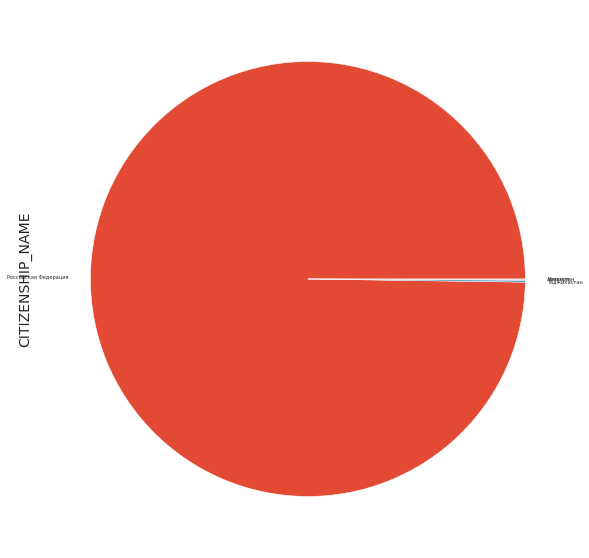

In [42]:
(train_data["CITIZENSHIP_NAME"].value_counts(normalize = True)*100).sort_values(ascending = False).plot(kind = "pie", fontsize = 5, figsize = (10,10));

*Some variables above show one dominating category. Re-grouping the rare label in this situation does not make any sense. We could determine if these variables are useful with exploratory analysis, or any feature selection algorithm, or drop the variables altogether.*

**Variables with few categories**

In [ ]:
# let's explore examples in which variables have several categories, say more than 10

multi_cat_cols = []

for col in train_data.columns:

    if train_data[col].dtypes =='O': # if variable  is categorical
    
        if 2 < train_data[col].nunique() <= 10: # has more than 2 but less than 10 categories
            
            multi_cat_cols.append(col)  # add to the list
            
            print(train_data.groupby(col)[col].count()/ len(train_data)) # and print the percentage of observations within each category
            
            print()

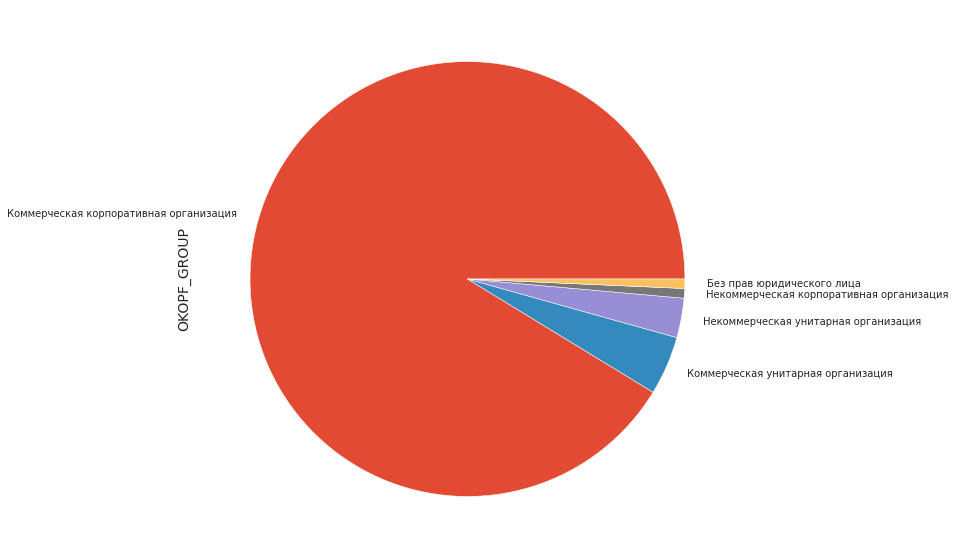

In [44]:
(train_data["OKOPF_GROUP"].value_counts(normalize = True)*100).sort_values(ascending = False).plot(kind = "pie", fontsize = 10, figsize = (10,10));

**Variable with high cardinality**

In [ ]:
# let's explore examples in which variables have several categories, say more than 10

multi_cat_cols = []

for col in train_data.columns:

    if train_data[col].dtypes =='O': # if variable  is categorical
    
        if train_data[col].nunique() > 10: # and has more than 10 categories
            
            multi_cat_cols.append(col)  # add to the list
            
            print(train_data.groupby(col)[col].count()/ len(train_data)) # and print the percentage of observations within each category
            
            print()

In [ ]:
(train_data["OKATO_REGIONCODE"].value_counts(normalize = True)*100).sort_values(ascending = False).plot(kind = "pie", fontsize = 10, figsize = (10,10));

**Re-grouping rare labels**

In [32]:
from feature_engine.encoding import RareLabelEncoder

In [33]:
# Rare value encoder
rare_encoder = RareLabelEncoder(
    tol=0.05,  # minimal percentage to be considered non-rare
    n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
    variables=features_categorical # variables to re-group
)  

In [34]:
rare_encoder.fit(train_data.drop(["TARGET"], axis=1))

RareLabelEncoder(n_categories=4,
                 variables=['OKTMO_CODE', 'OKVED_CODE', 'CITIZENSHIP_NAME',
                            'IP_flag', 'EGRPOINCLUDED', 'OKFS_GROUP',
                            'OKOPF_GROUP', 'OKOGU_GROUP', 'OKATO_REGIONCODE',
                            'OKATO_FED', 'OKTMO_FED', 'SEX_NAME',
                            'EGRPOINCLUDED_na', 'OKFS_GROUP_na',
                            'OKOPF_GROUP_na', 'OKOGU_GROUP_na',
                            'OKATO_REGIONCODE_na', 'OKATO_FED_na',
                            'OKTMO_CODE_na', 'OKTMO_FED_na', 'OKVED_CODE_na',
                            'THIRDOROTHERPERSON_YEAR_na',
                            'THIRDOROTHERPERSON_EVER_na', 'SEX_NAME_na',
                            'CITIZENSHIP_NAME_na', 'OKVED_CODE_2',
                            'OKVED_CODE_4', 'OKVED_CODE_5', 'OKVED_CODE_7',
                            'OKVED_CODE_8', ...])

In [35]:
X_train = rare_encoder.transform(train_data.drop(["TARGET"], axis=1))
X_test = rare_encoder.transform(test_data)

**Categorical Encoding using Count or frequency encoding** 

In count encoding we replace the categories by the count of the observations that show that category in the dataset.

The assumption of this technique is that the number observations shown by each variable is somewhat informative of the predictive power of the category.

Disadvantages

If 2 different categories appear the same amount of times in the dataset, that is, they appear in the same number of observations, they will be replaced by the same number: may lose valuable information.

In [36]:
# to encode with feature-engine
from feature_engine.encoding import CountFrequencyEncoder

In [37]:
count_enc = CountFrequencyEncoder(
    encoding_method='frequency',
    variables=features_categorical)

count_enc.fit(X_train)

CountFrequencyEncoder(encoding_method='frequency',
                      variables=['OKTMO_CODE', 'OKVED_CODE', 'CITIZENSHIP_NAME',
                                 'IP_flag', 'EGRPOINCLUDED', 'OKFS_GROUP',
                                 'OKOPF_GROUP', 'OKOGU_GROUP',
                                 'OKATO_REGIONCODE', 'OKATO_FED', 'OKTMO_FED',
                                 'SEX_NAME', 'EGRPOINCLUDED_na',
                                 'OKFS_GROUP_na', 'OKOPF_GROUP_na',
                                 'OKOGU_GROUP_na', 'OKATO_REGIONCODE_na',
                                 'OKATO_FED_na', 'OKTMO_CODE_na',
                                 'OKTMO_FED_na', 'OKVED_CODE_na',
                                 'THIRDOROTHERPERSON_YEAR_na',
                                 'THIRDOROTHERPERSON_EVER_na', 'SEX_NAME_na',
                                 'CITIZENSHIP_NAME_na', 'OKVED_CODE_2',
                                 'OKVED_CODE_4', 'OKVED_CODE_5', 'OKVED_CODE_7',
                  

In [38]:
# perform encoding
X_train = count_enc.transform(X_train)
X_test = count_enc.transform(X_test)

In [39]:
# check for presence of object type columns
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14312 entries, 3391 to 11481
Columns: 374 entries, OKTMO_CODE to MANAGERINNCOUNT_std
dtypes: float64(251), int64(123)
memory usage: 40.9 MB


# Exploratory Analysis with Statistics

As our data is cleaned, we will explore our data with descriptive and graphical statistics to describe and summarize our variables.

In [ ]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1)

# Fitting with other classification algorithms

In [ ]:
# checking

print("Columns with missing values in train set:")
[feature for feature in X_train.columns if X_train.isnull().any()[feature] == True]

Columns with missing values in train set:


[]

https://www.kaggle.com/andreyrus/tps-apr-rf-with-intel-extension-for-scikit-learn/notebook

In [48]:
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True) # make learning a little bit faster

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    # #Ensemble Methods
    # ensemble.AdaBoostClassifier(),
    # ensemble.BaggingClassifier(),
    # ensemble.ExtraTreesClassifier(),
    # ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier()

    # #Gaussian Processes
    # gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    # linear_model.LogisticRegressionCV(),
    # linear_model.PassiveAggressiveClassifier(),
    # linear_model.RidgeClassifierCV(),
    # linear_model.SGDClassifier(),
    # linear_model.Perceptron(),
    
    # #Navies Bayes
    # naive_bayes.BernoulliNB(),
    # naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    # neighbors.KNeighborsClassifier(),
    
    #SVM
    # svm.SVC(probability=True),
    # svm.NuSVC(probability=True),
    # svm.LinearSVC(),
    
    # #Trees    
    # tree.DecisionTreeClassifier(),
    # tree.ExtraTreeClassifier(),
    
    # #Discriminant Analysis
    # discriminant_analysis.LinearDiscriminantAnalysis(),
    # discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    # #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    # XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)


#create table to compare MLA predictions
target = train_data["TARGET"].values.reshape((14312,1))
MLA_predict = train_data["TARGET"]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, X_train, target, cv  = cv_split, n_jobs = -1, scoring = "roc_auc", return_train_score=True, verbose=True) # turn on all cores
    print(f"Model {MLA_name} is trained")
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(X_train, target)
    MLA_predict[MLA_name] = alg.predict(X_train)
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.6s finished


Model RandomForestClassifier is trained


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1,0.951151,0.0102761,9.456


In [53]:
pickle_out = open(path_pikcle + "MLA_compare.pickle", "wb")
pickle.dump(MLA_compare, pickle_out)
pickle_out.close()

# Other algorithms vs CatBoost

In [54]:
pickle_in = open(path_pikcle + "cat_boost_model_first.pickle", "rb")
cat_boost_model_first = pickle.load(pickle_in)
pickle_in = open(path_pikcle + "MLA_compare.pickle", "rb")
MLA_compare = pickle.load(pickle_in)

In [56]:
cv_cat_results = cat_boost_model_first[0][0]
fit_time = cat_boost_model_first[1]

In [57]:
cv_cat_results["MLA Name"] = "CatBoost"
cv_cat_results["MLA Time"] = fit_time

In [58]:
cv_cat_results = cv_cat_results.rename(columns={"test-AUC-mean":"MLA Test Accuracy Mean", "test-AUC-std":"MLA Test Accuracy 3*STD"});

In [59]:
cv_cat_results = cv_cat_results[['MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Name', 'MLA Time']].max()

In [60]:
MLA_compare = MLA_compare.append(cv_cat_results, ignore_index=True).sort_values(by = "MLA Test Accuracy Mean")

Text(0, 0.5, 'Algorithm')

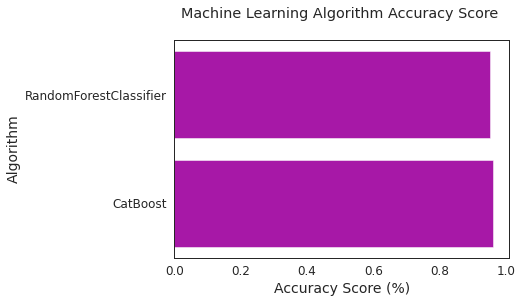

In [61]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

Obviously, CatBoost overperform XGBClassifier and RandomForestClassifier by 11111 % in terms of test score. But Catboost is slower by 111111 %.

Nevetheless futher we will focus only on Catboost.

# Feature selection by CatBoost

In [ ]:
feature_importance_df = cbc_2.get_feature_importance(prettified=True)

In [ ]:
feature_importance_df = feature_importance_df.loc[feature_importance_df["Importances"] > 0.5]
feature_importance_df

,Feature Id,Importances
0,F_contract_count_in_day_std,13.790187
1,OKVED_CODE_na,7.381221
2,F_contract_count_mean,5.009237
3,F_contract_count,4.755740
4,OKVED_CODE_5,4.718441
5,F_WORKERSRANGE_change_mean,3.263914
6,OKTMO_CODE_8,3.192605
7,OKVED_CODE,2.984926
8,DATEFIRSTREG_na,2.698245
9,OKVED_CODE_2,2.666958


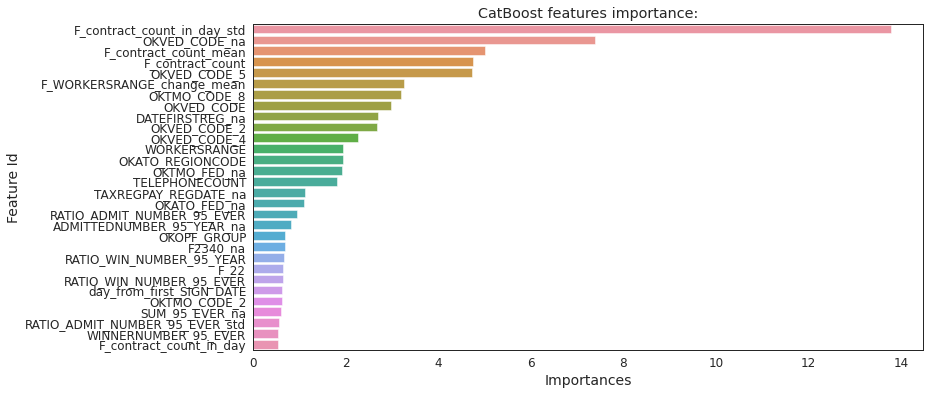

In [ ]:
plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=feature_importance_df);
plt.title('CatBoost features importance:');

In [ ]:
train_data_cat = Pool(data=X_train_cat,
                  label=y_train_cat,
                  cat_features=cat_features
                 )

In [ ]:
import shap
explainer = shap.TreeExplainer(cbc_2) # insert your model
shap_values = explainer.shap_values(train_data_cat) # insert your train Pool object

In [ ]:
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])

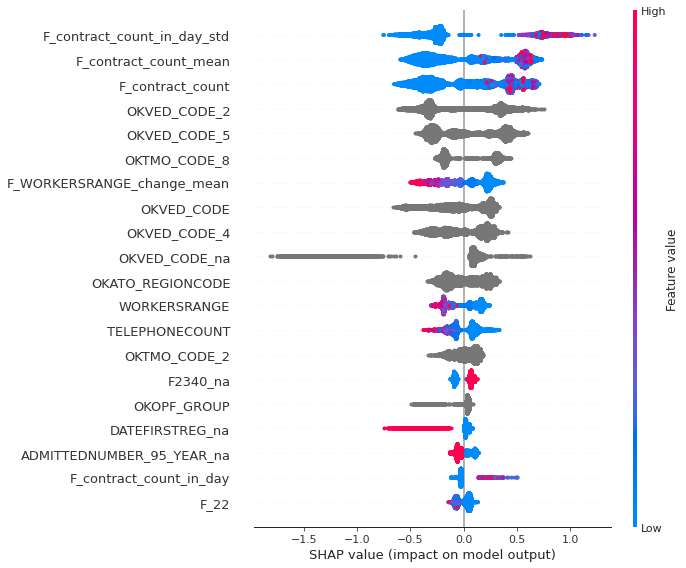

In [ ]:
shap.summary_plot(shap_values, X_train_cat)

On the above diagram every client (instance/row in our dataset) is represented by one dot in each row. The x position of the dot is the impact of that feature on the model’s prediction, and the color of the dot represents the value of that feature for that exact employee. Dots that do not fit on the row pile up to show density.

https://www.kaggle.com/dansbecker/shap-values

# Final model

https://www.kaggle.com/bairamosmanov/tutorial-catboost-overview/edit

In [65]:
%%time

from sklearn.model_selection import StratifiedKFold

n_fold = 4 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=SEED)

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': SEED
         }

test_data = Pool(data=X_test_cat,
                 cat_features=cat_features)

scores = []
prediction = np.zeros(X_test_cat.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
    y_train, y_valid = y[train_index], y[valid_index]
    
    train_data = Pool(data=X_train, 
                      label=y_train,
                      cat_features=cat_features)
    valid_data = Pool(data=X_valid, 
                      label=y_valid,
                      cat_features=cat_features)
    
    model = CatBoostClassifier(**params)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold
print('CV mean: {:.4f}, CV std: {:.4f}'.format(np.mean(scores), np.std(scores)))

Learning rate set to 0.056952
0:	test: 0.9010017	best: 0.9010017 (0)	total: 149ms	remaining: 2m 28s
200:	test: 0.9635621	best: 0.9636104 (197)	total: 32.8s	remaining: 2m 10s
400:	test: 0.9636903	best: 0.9638933 (234)	total: 59.3s	remaining: 1m 28s
600:	test: 0.9625198	best: 0.9638933 (234)	total: 1m 25s	remaining: 57s
800:	test: 0.9621751	best: 0.9638933 (234)	total: 1m 52s	remaining: 27.9s
999:	test: 0.9621860	best: 0.9638933 (234)	total: 2m 18s	remaining: 0us

bestTest = 0.9638932921
bestIteration = 234

Shrink model to first 235 iterations.
Learning rate set to 0.056952
0:	test: 0.9036054	best: 0.9036054 (0)	total: 142ms	remaining: 2m 22s
200:	test: 0.9612307	best: 0.9614357 (158)	total: 27.2s	remaining: 1m 48s
400:	test: 0.9615478	best: 0.9616367 (250)	total: 53.6s	remaining: 1m 20s
600:	test: 0.9619599	best: 0.9619599 (600)	total: 1m 19s	remaining: 53.1s
800:	test: 0.9621557	best: 0.9621922 (686)	total: 1m 46s	remaining: 26.4s
999:	test: 0.9622402	best: 0.9623136 (925)	total: 2m 1

In [66]:
pickle_out = open(path_pikcle + "cat_boost_model_final.pickle", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()

# Evaluate Model Performance



In [67]:
pickle_in = open(path_pikcle + "cat_boost_model_final.pickle", "rb")
cat_boost_model_final = pickle.load(pickle_in)

In [81]:
X_final = X_test_cat
X_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3579 entries, 14312 to 17890
Columns: 374 entries, OKTMO_CODE to MANAGERINNCOUNT_std
dtypes: float64(218), int64(123), object(33)
memory usage: 10.2+ MB


In [82]:
Y_final = list_data[1].copy()["TARGET"]
Y_final

14312    1
14313    0
14314    0
14315    1
14316    0
        ..
17886    1
17887    1
17888    1
17889    0
17890    0
Name: TARGET, Length: 3579, dtype: int64

In [90]:
cat_boost_model_final.score(X_final, Y_final).round(4)

0.9084

**Final score on unseen test data - 0.9084**

# Tune Model with Hyper-Parameters

# Tune Model with Feature Selection

# Validate and Implement

# Optimize and Strategize

# Future Research